# Chapter 5 - Calculating Network Error with Loss

In [38]:
!pip install nnfs

# Categorical cross entropy error
L = -SUM(y_true * log(y_pred))

In fact, it is the same that calculating only -log(softmax_output[ground_truth==1]). Thus, we only do one operation instead of multiplying 
0 labels by softmax probability.

In [3]:
import math 

# An example output from the output layer of the neural network
softmax_output = [0.7, 0.1, 0.2]

# Ground Truth
target_output = [1, 0, 0]

# -(1 * log(0.7) + 0 * ... + 0 * ...)
# = - log(0.7)

loss = -(math.log(softmax_output[0]) * target_output[0] + 
         math.log(softmax_output[1]) * target_output[1] + 
         math.log(softmax_output[2]) * target_output[2])

# - log(0.7)
loss_reduced = -(math.log(softmax_output[target_output==1]))

print(loss, loss_reduced, loss == loss_reduced)

0.35667494393873245 0.35667494393873245 True


# Here we see that log values near to 1 tend to zero, but values near to zero are bigger (forget about the minus because the formula multiplies by - to make the value positive). Then, the greater the probability, the smallest the loss.

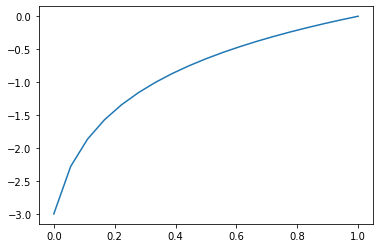

In [22]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.05, 1, 19)

xx = [math.log(i) for i in x]

plt.plot(np.linspace(0, 1, len(xx)),xx)

In [31]:
softmax_outputs = np.array([[0.7, 0.1, 0.2],
                           [0.1, 0.5, 0.4],
                           [0.02, 0.9, 0.08]])
class_targets = [0, 1, 1]

# we can get the target probabilities of softmax_outputs directly with numpy
# we can use a list of indices to get values from a numpy array

# for example
a = np.array([[1,2,3], [4,5,6], [7,8,9]])
b = [1, 2, 0]

print(a[[0, 1, 2], b])

print(softmax_outputs[range(len(softmax_outputs)), class_targets])

# then, now we can calculate the -log
loss = -np.log(softmax_outputs[range(len(softmax_outputs)), class_targets])

print(loss)

# now, we want to calculate the average loss of the whole batch
# to see how our model is performing
avg_loss = np.mean(loss)

print(avg_loss)

[2 6 7]
[0.7 0.5 0.9]
[0.35667494 0.69314718 0.10536052]
0.38506088005216804


# The Categorical Cross-Entropy Loss Class

In [35]:
# first, we create our global loss class. If we use more than one loss, i.e. for
# object detection, the global loss is the mean value between class loss and 
# box loss.

# Common loss class
class Loss:

  # Calculates the data and regularizations losses given model output and
  # ground truth values
  def calculate(self, output, y):

    # Calculate sample losses
    sample_losses = self.forward(output, y)

    # Calculate mean loss
    data_loss = np.mean(sample_losses)

    # Return loss
    return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

  # Forward pass
  def forward(self, y_pred, y_true):

    # Number of samples in a batch
    samples = len(y_pred)

    # Clip data to prevent division by 0 when calculating log. We have to avoid
    # calculating log(0). Then, we clip all the output values from softmax between
    # 1e-7 and 1-1e-7.
    y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

    # Probabilities for target values - only if categorical labels
    # this is for sparse labels [0, 2, 5, 1], each value is a label
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples), y_true]

    # for one hot encoded labels, we multiply each softmax output
    # by the label
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)


    # Losses
    negative_log_likelihoods = -np.log(correct_confidences)

    return negative_log_likelihoods

In [42]:
"""# example

loss_function = Loss_CategoricalCrossentropy()
loss = loss_function.calculate(softmax_outputs, np.asarray(class_targets))

print(loss)"""

'# example\n\nloss_function = Loss_CategoricalCrossentropy()\nloss = loss_function.calculate(softmax_outputs, np.asarray(class_targets))\n\nprint(loss)'

# Combining everything up to this point

In [36]:
class Layer_Dense:

  def __init__(self, n_inputs, n_neurons):
    """
    Initialise weights and biases
    random.randn returns a matrix with n_inputs x n_neurons shape
    it makes sense to create the weights matrix with inputs x neurons shape
    NUMBER OF WEIGHTS VALUES = NUMBER OF INPUTS X NUMBER OF NEURONS
    
    note that we define the shape as inputs X neurons and not neurons X inputs
    to avoid transposing every time we do a forward pass
    
        4 inputs, 3 neurons
        wij -> weight, i -> input value, j -> neuron 
        [w11, w12, w13]
        [w21, w22, w23]
        [w31, w32, w33]
        [w41, w42, w43]

        each column is already a vector of weights of each neuron for the input
    
    random.randn generates values from a Gaussian distribution with a mean of 0
    and a variance of 1, which mean that it'll generate random numbers, positive and
    negative [-1,1], centered at 0 and with the mean value close to 0.
    
    we multiply here by 0.01 because we want to initialise weights with non-zero values
    but these values have to be small because training updates will be smaller. 
    If weight values are very big, the training will last more time.
    
    """
    
    self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
    # ONE BIAS VALUE FOR EACH NEURON
    self.biases = np.zeros((1, n_neurons))


  # Forward pass
  def forward(self, inputs):
    # Calculate outputs values from inputs, weights and biases
    self.output = np.dot(inputs, self.weights) + self.biases

# --------------------------------------------------------
# ReLU activation class
class Activation_ReLU:

  # Forward pass
  def forward(self, inputs):
    # Calculate output values from input
    self.output = np.maximum(0, inputs)


# -------------------------------------------------------
# Softmax activation class
class Activation_Softmax:

  # Forward pass
  def forward(self, inputs):
    
    # Get unnormalized probabilities
    exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    self.output = probabilities

In [50]:
import nnfs 
from nnfs.datasets import spiral_data

nnfs.init()
# create dataset
X, y = spiral_data(samples=100, classes=3)  # samples per class

# -----------------model------------

# create dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to beb used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create softmax activation (to be used with dense layer)
activation2 = Activation_Softmax()

# Create loss function 
loss_function = Loss_CategoricalCrossentropy()

# ----------------forward------------

# Perform a forward pass of our training data through this layer
dense1.forward(X)

# Forward pass through activation func.
# Takes in output from previous layer
activation1.forward(dense1.output)

# Make a forward pass through second dense layer
# it takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# in softmax, the number of inputs is the number of final classes
# here we have 3 classes
activation2.forward(dense2.output)

# Perform a forward pass through loss function 
# it takes the output of the softmax layer here and returns loss
# y is sparse
loss = loss_function.calculate(activation2.output, y)

print("loss: ", loss)

# Accuracy calculation
predictions = np.argmax(activation2.output, axis=1)

# if labels are one-hot encoded, convert them to sparse
if len(y.shape) == 2:
  y = np.argmax(y, axis=1)

accuracy = np.mean(predictions==y)

print("accuracy: ", accuracy)

loss:  1.0986104
accuracy:  0.34
